#### Estimates of a Hawkes process

#### Ayoub Benabbou

# Loading the data

In [3]:
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize,root_scalar
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
from scipy.integrate import quad

In [4]:
df = pd.read_csv(r"C:\Users\dell\Desktop\Projets_TP_23_24\PRC.csv", sep=';')

In [5]:
df.head()

,Date Made Public,Company,City,State,Type of breach,Type of organization,Total Records,Description of incident,Information Source,Source URL,Year of Breach,Latitude,Longitude,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,3/3/2006,PayDay OK LLC,NaN,New Jersey,HACK,BSF,88,The company's website was breached sometime ar...,California Attorney General,https://oag.ca.gov/,2006,40.058324,-74.405661,NaN,NaN,NaN
1,1/4/2012,"SF Fire Credit Union, Pacifica-Coastside Credi...",San Francisco,California,PORT,BSF,0,"The December 29, 2011 theft of a laptop from a...",California Attorney General,NaN,2012,37.774930,-122.419416,NaN,NaN,NaN
2,2/18/2012,"BDO USA, Rubio's Restaurants, Inc.",San Diego,California,PORT,BSR,0,BDO was contracted by Rubio's to perform finan...,California Attorney General,NaN,2012,32.715329,-117.157255,NaN,NaN,NaN
3,2/22/2012,"DHI Mortgage Company, Ltd.",Austin,Texas,HACK,BSF,0,"On February 10, 2012, DHI Mortgage became awar...",California Attorney General,NaN,2012,30.267153,-97.743061,NaN,NaN,NaN
4,3/12/2012,"Impairment Resources, LLC",San Diego,California,PORT,MED,"14,000",An office burglary on New Year's Eve 2011 resu...,California Attorney General,NaN,2012,32.715329,-117.157255,NaN,NaN,NaN


In [6]:
df_hack=df.loc[df['Type of breach']=="HACK",'Date Made Public']
df_hack=df_hack.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))

In [7]:
df_hack.head()

0    2006-03-03
3    2012-02-22
8    2012-03-23
15   2012-04-09
16   2012-04-11
Name: Date Made Public, dtype: datetime64[ns]

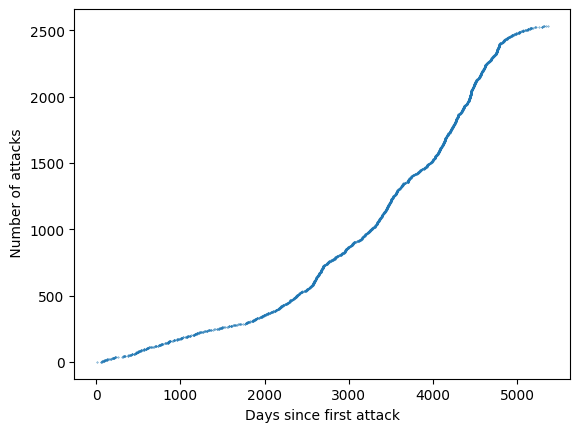

In [8]:
debut=min(df_hack)
df_hack=df_hack-debut

df_hack = df_hack.apply(lambda x: x.days).sort_values()
# l contains the time between the attack at index i and first attack
l=np.asarray(df_hack)[1:]
# plotting in function of range ... it respresents the number of attacks
plt.scatter(l , 1+np.arange(len(l)) , s=0.1)
plt.xlabel( "Days since first attack")
plt.ylabel( " Number of attacks" )
plt.show()

# Optimal parameters

We first provide a proof for the expression of the log-likelihood function:

The expression of the intensity of the hawk process is
\begin{equation}
\dot{y}(N, t)=\alpha+\beta \int_0^{t^{-}} e^{-\gamma(t-s)} \mathrm{d} N(s)
\end{equation}

As we did in the exercise of the polycopié, we integrate this equation:
$$
y(N, t)=\alpha t+\beta \int_0^t \int_0^s e^{-\gamma(s-r)} \mathrm{d} N(r) \mathrm{d} s .
$$
By the Fubini-Tonnelli Theorem
$$
\begin{aligned}
\int_0^t \int_0^s e^{-\gamma(s-r)} \mathrm{d} N(r) \mathrm{d} s & =\int_0^t \int_r^t e^{-\gamma(s-r)} \mathrm{d} s \mathrm{~d} N(r) \\
& =\int_0^t \int_0^{t-r} e^{-\gamma s} \mathrm{~d} s \mathrm{~d} N(r) \\
& =\frac{1}{\gamma} \int_0^t\left(1-e^{-\gamma(t-r)}\right) \mathrm{d} N(r) \\
& =\frac{1}{\gamma} \sum_{T_n \leq t}\left(1-e^{-\gamma\left(t-T_n\right)}\right)
\end{aligned}
$$
Hence,
$$
y(N, t)=\alpha t+\frac{\beta}{\gamma} \sum_{T_n \leq t}\left(1-e^{-\gamma\left(t-T_n\right)}\right)
$$
And so,
\begin{aligned}
\log L(N, t)= & \sum_{T_n \leq t} \log \left(\alpha+\beta \sum_{j=1}^{n-1} e^{-\gamma\left(T_n-T_j\right)}\right)
+(1-\alpha) t-\frac{\beta}{\gamma} \sum_{T_n \leq t}\left(1-e^{-\gamma\left(t-T_n\right)}\right) \cdot
\end{aligned}

In [9]:
#Defining the log-likelihood function
def log_likelihood(alpha, beta, gamma, attack_times, current_time):
    total_log_likelihood = (1 - alpha) * current_time
    i = 0
    while i < len(attack_times) and attack_times[i] < current_time:
        diffs = attack_times[i] - attack_times[:i]
        sum_exponentials = np.sum(np.exp(-gamma * diffs))
        log_term = np.log(alpha + beta * sum_exponentials)
        exponential_term = beta / gamma * (1 - np.exp(-gamma * (current_time - attack_times[i])))
        total_log_likelihood += log_term - exponential_term
        i += 1
    return total_log_likelihood


In [10]:
# Minimization of the log-likelihood function to find the optimal parameters
from scipy.optimize import minimize
def find_optimal_parameters(attack_times, current_time):
    # Constraint: beta / gamma >= 1
    constraint = {'type': 'ineq', 'fun': lambda x: x[1] / x[2] - 1}
    
    # Bounds for the parameters (alpha, beta, gamma)
    bounds = ((0, None), (0, None), (0, None))
    
    # Minimize the negative log-likelihood to maximize the likelihood
    result = minimize(lambda x: -log_likelihood(x[0], x[1], x[2], attack_times, current_time),
                      x0=[1, 0.5, 1], method='L-BFGS-B', bounds=bounds, constraints=constraint)
    
    return result.x


In [11]:
# find the optimal parameters for the whole dataset
alpha,beta,gamma=find_optimal_parameters(l,l[-1])
print("alpha = ",alpha)
print("beta = ",beta)
print("gamma = ",gamma)

C:\Users\dell\AppData\Local\Temp\ipykernel_12580\1329070739.py:11: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  result = minimize(lambda x: -log_likelihood(x[0], x[1], x[2], attack_times, current_time),
C:\Users\dell\AppData\Local\Temp\ipykernel_12580\1746133740.py:8: RuntimeWarning: divide by zero encountered in log
  log_term = np.log(alpha + beta * sum_exponentials)
c:\Python310\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


alpha =  0.998665354969612
beta =  0.499332677484806
gamma =  1.9999988867010323


# Intensity and Componsator computation

In [12]:
def y_point(alpha, beta, gamma, attack_times, current_time):
    derivative = alpha
    for time in attack_times:
        if time < current_time:
            diff = current_time - time
            derivative += beta * np.exp(-gamma * diff)
    return derivative

y_point = [y_point(alpha,beta,gamma,l,t) for t in l]

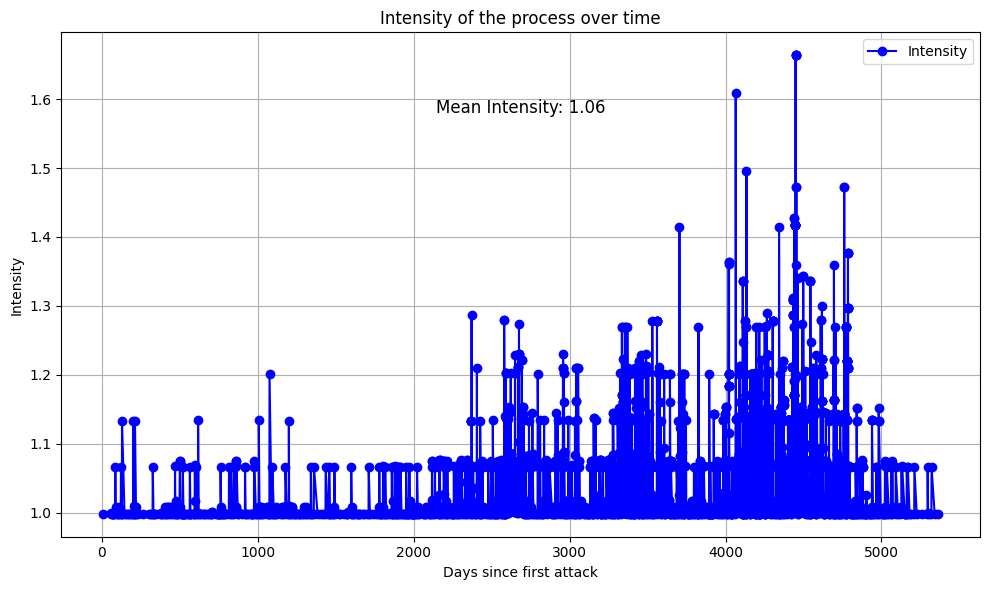

In [14]:
plt.figure(figsize=(10, 6))  # Adjusted figure size
plt.plot(l, y_point, marker='o', linestyle='-', color='b', label='Intensity')
plt.xlabel("Days since first attack")
plt.ylabel("Intensity")
plt.title("Intensity of the process over time")
plt.grid(True)  # Adding grid lines
plt.legend()  # Adding legend

# Adding mean intensity text
mean_intensity = np.mean(y_point).round(4)
plt.text(0.5, 0.85, f"Mean Intensity: {mean_intensity}", ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()  # Adjusting layout to prevent overlap
plt.show()


The values of $\dot{y}(N, t)$  are generally close to  1, and their mean value is 1.06

# Generating the associated process

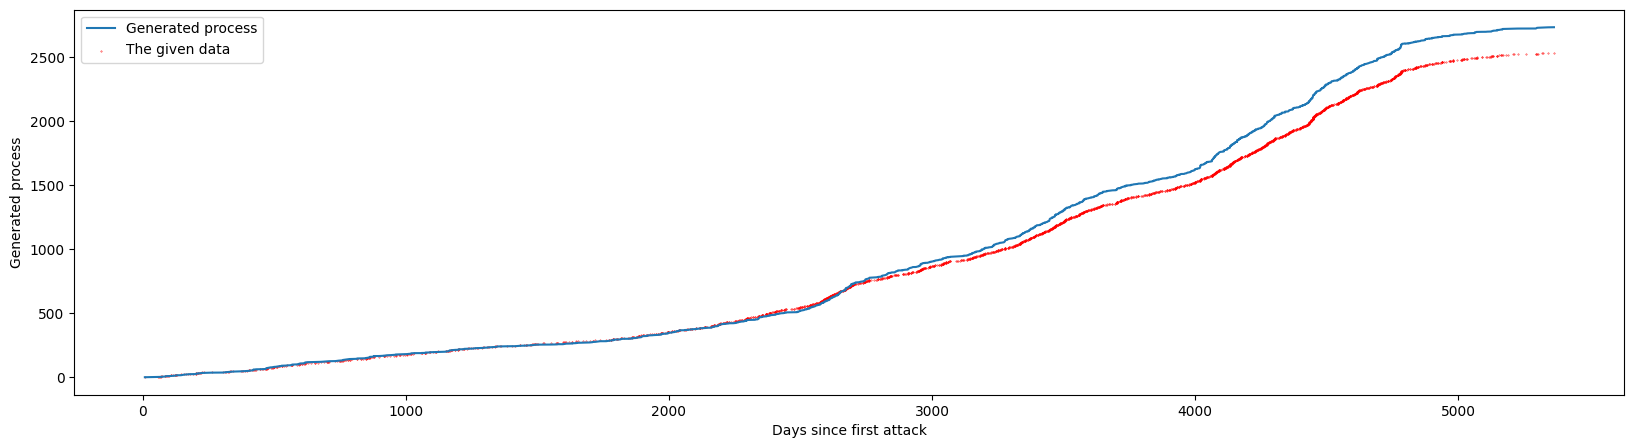

In [18]:
# generate process from derivs
def generate_process(l,derivs):
    d = np.zeros(len(l))
    for i in range(1,len(l)):
        d[i] = d[i-1] + np.random.exponential(derivs[i])
    return d

# plot the generated process
plt.figure(figsize=(20, 5))
gen_process = generate_process(l,y_point)
plt.plot(l,gen_process,label='Generated process')
plt.scatter(l , 1+np.arange(len(l)) , s=0.1 , c='r' , label='The given data')
plt.xlabel( "Days since first attack")
plt.ylabel( "Generated process" )
plt.legend()
plt.show()



# Testing the closenes to the law of Poisson Process

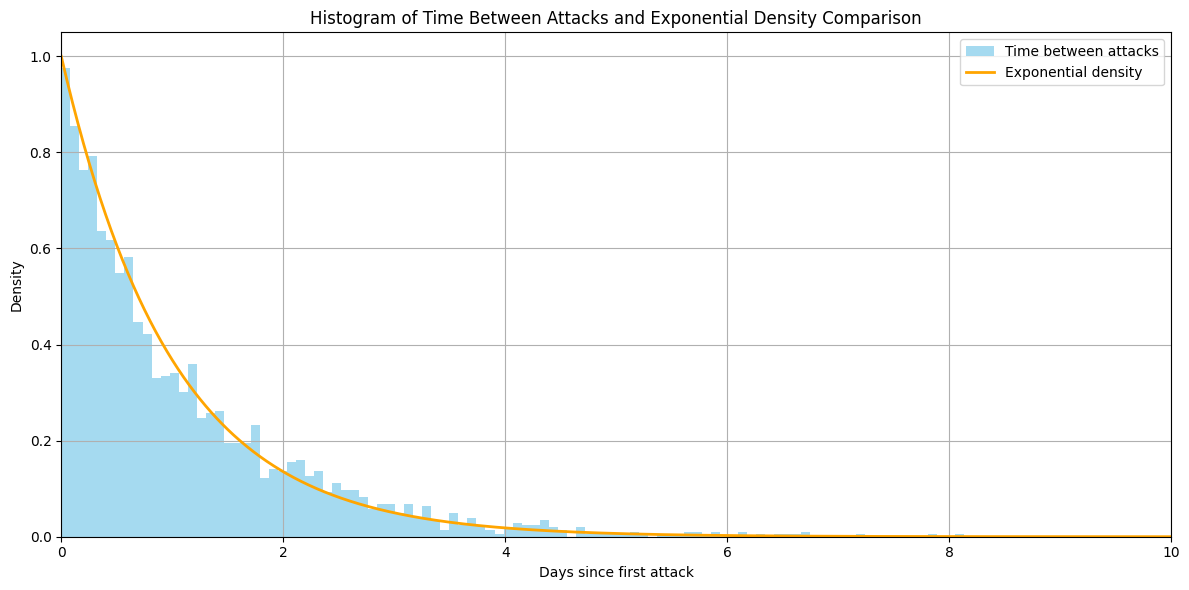

In [19]:
# Calculate time between attacks
time_between_attacks = gen_process - np.append([0], gen_process[:-1])

# Plotting
plt.figure(figsize=(12, 6))  # Adjusted figure size
plt.hist(time_between_attacks, bins=100, density=True, label='Time between attacks', color='skyblue', alpha=0.75)

# Plotting the exponential density
grid = np.linspace(0., 10, 1000)  # Adjusted grid range
exp_density = np.exp(-grid)
plt.plot(grid, exp_density, label='Exponential density', color='orange', linewidth=2)

plt.xlabel("Days since first attack")
plt.xlim(0, 10)
plt.ylabel("Density")
plt.title("Histogram of Time Between Attacks and Exponential Density Comparison")
plt.legend()

plt.grid(True)  # Adding grid lines
plt.tight_layout()  # Adjusting layout to prevent overlap

plt.show()

We can also use the Kolmogorov-Smirnov test to compare the samples we've simulated (using $y(N, t)$) with a reference probability distribution, specifically an exponential distribution in this case.

The Kolmogorov-Smirnov statistic measures the distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution.

The null hypothesis states that the sample is drawn from the reference distribution.

The empirical distribution function $F_n$​ for $n$ independent and identically distributed observations $\xi_i$​ is defined as:

$$F_n(t) = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}_{\{\xi_i \leq t\}}$$

The KS statistic is defined as :
$$D_n = \sup_{t \in \mathbb{R}^{+}} |F_n(t) - F(t)|$$

If the sample comes from distribution $F$, then $D_n$ converges to 0 almost surely when $n$ goes to $\infty$.

In [ ]:
# Kolmogorov-Smirnov test

intervals = gen_process - np.append([0], gen_process[:-1])
ks = stats.kstest(intervals, 'expon', args=(0, np.mean(intervals)))
D_n = ks.statistic
print(f"The Kolmogorov-Smirnov statistic is : {D_n:.4f}")

The Kolmogorov-Smirnov statistic is : 0.0176


From the graphical results, and the result o the statisitc, which is low, we can conclude that the process generated correspoding to the given inter-arrivals is indeed a Poisson process of intensity 1